# **CODE - COMPUTER VISION PROJECT**

---



# Setup

## Installation des librairies

In [23]:
# Détection d'objets
!pip install ultralytics  # YOLO v8
!pip install torch torchvision

# OCR
!pip install easyocr pytesseract

# Vision-Language
!pip install transformers pillow

# Utilitaires
!pip install opencv-python-headless numpy matplotlib

In [24]:
!pip install ultralytics opencv-python-headless pillow numpy matplotlib
!pip install gtts playsound  # Pour la synthèse vocale


  Using cached gTTS-2.5.4-py3-none-any.whl.metadata (4.1 kB)
  Using cached playsound-1.3.0.tar.gz (7.7 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [23 lines of output]
      Traceback (most recent call last):
        File "/Users/victormicha/PythonProjects/IP_Paris/ImageAnalysisCV_EP/Visual-Assistant-for-the-Visually-Impaired/.venv/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
        File "/Users/victormicha/PythonProjects/IP_Paris/ImageAnalysisCV_EP/Visual-Assistant-for-the-Visually-Impaired/.venv/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
        File "/Users/victormicha/PythonProjects/IP_Paris/ImageAnalys

## Imports

In [25]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
from pathlib import Path
from collections import Counter

In [26]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

PyTorch version: 2.9.1
CUDA disponible: False


# Module 1 : Yolo - Détéction d'objets

## Chargement du modèle

In [27]:
# Chargement du modèle YOLOv8 pré-entraîné sur COCO
# Options: yolov8n (nano - rapide), yolov8s (small), yolov8m (medium), yolov8l (large)
model = YOLO('yolov8n.pt')
print(f"Classes disponibles: {len(model.names)} catégories")

Classes disponibles: 80 catégories


## Détéction des obstacles et zones dangereuses

In [28]:
OBSTACLES_CRITIQUES = {
    'person': 'Personne détectée',
    'car': 'Véhicule',
    'truck': 'Camion',
    'bus': 'Bus',
    'bicycle': 'Vélo',
    'motorcycle': 'Moto',
    'traffic light': 'Feu de circulation',
    'stop sign': 'Stop',
    'bench': 'Banc',
    'chair': 'Chaise',
    'stairs': 'Escaliers',
    'dog': 'Chien',
    'cat': 'Chat'
}

# Zones de danger (distance basée sur la taille de la bbox)
def evaluer_distance(bbox_area, image_area):
    """
    Estime la proximité basée sur la taille de la boîte englobante
    """
    ratio = bbox_area / image_area
    if ratio > 0.3:
        return "TRÈS PROCHE - ATTENTION"
    elif ratio > 0.15:
        return "Proche"
    elif ratio > 0.05:
        return "Distance moyenne"
    else:
        return "Loin"

## Fonction de détéction et analyse

In [29]:
def detecter_et_analyser(image_path, conf_threshold=0.5):
    """
    Détecte les objets dans une image et génère des alertes vocales

    Args:
        image_path: chemin vers l'image
        conf_threshold: seuil de confiance minimum (0-1)

    Returns:
        image annotée, liste des détections, alertes
    """
    # Lecture de l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: impossible de charger {image_path}")
        return None, None, None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    image_area = h * w

    # Détection
    results = model(image, conf=conf_threshold, verbose=False)

    # Analyse des résultats
    detections = []
    alertes = []

    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Extraction des informations
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            xyxy = box.xyxy[0].cpu().numpy()

            class_name = model.names[cls]

            # Calculer la taille de la bbox
            bbox_area = (xyxy[2] - xyxy[0]) * (xyxy[3] - xyxy[1])
            distance = evaluer_distance(bbox_area, image_area)

            # Position (gauche, centre, droite)
            center_x = (xyxy[0] + xyxy[2]) / 2
            if center_x < w / 3:
                position = "à gauche"
            elif center_x < 2 * w / 3:
                position = "devant vous"
            else:
                position = "à droite"

            detection = {
                'classe': class_name,
                'confiance': conf,
                'bbox': xyxy,
                'distance': distance,
                'position': position
            }
            detections.append(detection)

            # Générer alerte si obstacle critique
            if class_name in OBSTACLES_CRITIQUES:
                alerte = f"{OBSTACLES_CRITIQUES[class_name]} {position}, {distance}"
                alertes.append(alerte)

    # Annoter l'image
    annotated_image = results[0].plot()
    annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    return annotated_image, detections, alertes

## Fonction de synthèse vocale (description de la scène)

In [30]:
def generer_description_scene(detections):
    """
    Génère une description textuelle de la scène pour synthèse vocale
    """
    if not detections:
        return "Aucun objet détecté dans la scène."

    # Compter les objets
    objets = [d['classe'] for d in detections]
    compteur = Counter(objets)

    # Filtrer les obstacles critiques
    obstacles = [d for d in detections if d['classe'] in OBSTACLES_CRITIQUES]

    description = "Analyse de la scène : "

    # Décrire les obstacles critiques en priorité
    if obstacles:
        description += f"{len(obstacles)} obstacle(s) détecté(s). "
        for obs in obstacles[:3]:  # Limiter aux 3 plus importants
            description += f"{OBSTACLES_CRITIQUES[obs['classe']]} {obs['position']}, {obs['distance'].lower()}. "

    # Ajouter un résumé général
    description += f"Au total, {len(detections)} objets dans la scène : "
    for obj, count in compteur.most_common(5):
        description += f"{count} {obj}, "

    return description.rstrip(", ") + "."

## Visualisation

In [31]:
def afficher_resultats(image_path, conf_threshold=0.5):
    """
    Affiche les résultats de détection avec alertes
    """
    annotated_image, detections, alertes = detecter_et_analyser(image_path, conf_threshold)

    if annotated_image is None:
        return

    plt.figure(figsize=(15, 10))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.title(f"Détection d'objets - {len(detections)} objets détectés", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Afficher les alertes

    if alertes:
        for i, alerte in enumerate(alertes, 1):
            print(f"{i}.  {alerte}")
    else:
        print("Aucun obstacle critique détecté")

    # Description de scène
    description = generer_description_scene(detections)
    print(description)

    # Détails des détections
    for i, det in enumerate(detections, 1):
        print(f"{i}. {det['classe']} (confiance: {det['confiance']:.2f}) - "
              f"{det['position']}, {det['distance']}")

## Test sur image

Test sur une image d'exemple:


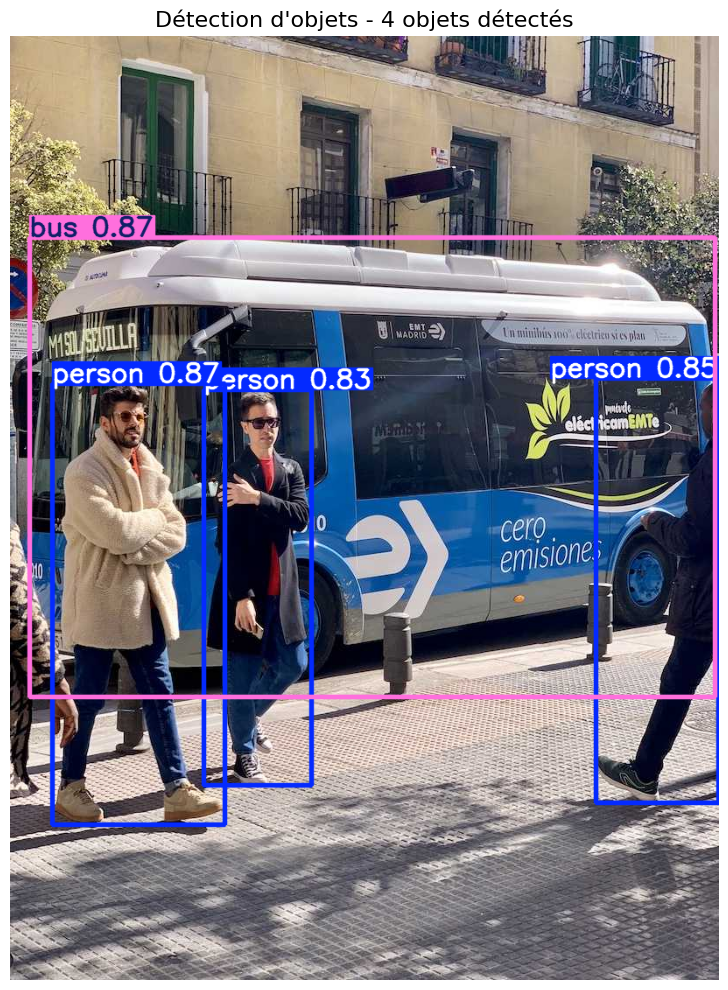

1.  Bus devant vous, TRÈS PROCHE - ATTENTION
2.  Personne détectée à gauche, Distance moyenne
3.  Personne détectée à droite, Distance moyenne
4.  Personne détectée devant vous, Distance moyenne
Analyse de la scène : 4 obstacle(s) détecté(s). Bus devant vous, très proche - attention. Personne détectée à gauche, distance moyenne. Personne détectée à droite, distance moyenne. Au total, 4 objets dans la scène : 3 person, 1 bus.
1. bus (confiance: 0.87) - devant vous, TRÈS PROCHE - ATTENTION
2. person (confiance: 0.87) - à gauche, Distance moyenne
3. person (confiance: 0.85) - à droite, Distance moyenne
4. person (confiance: 0.83) - devant vous, Distance moyenne


In [32]:
#TEST SUR IMAGE D'EXEMPLE
!wget -q https://ultralytics.com/images/bus.jpg -O test_image.jpg

print("Test sur une image d'exemple:")
afficher_resultats('test_image.jpg', conf_threshold=0.5)

#TEST SUR NNOS PROPRES IMAGES

#afficher_resultats('nom.jpg')

#possible de traiater plusieurs images


## Détéction sur vidéo

NB : On peut utiliser des vidéos faites par nous mêmes ou bien prendre des POV walking in the street sur youtube. Il faudrait qu'on essaye de tester plusieurs scènes, typiquement supermarché, pharamcie, parc, etc.

In [33]:
!wget https://www.pexels.com/download/video/3571264/ -O street_walking.mp4

--2025-12-03 15:06:55--  https://www.pexels.com/download/video/3571264/
Resolving www.pexels.com (www.pexels.com)... 2606:4700::6812:43dc, 2606:4700::6812:42dc, 104.18.66.220, ...
Connecting to www.pexels.com (www.pexels.com)|2606:4700::6812:43dc|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://videos.pexels.com/video-files/3571264/3571264-uhd_3840_2160_30fps.mp4 [following]
--2025-12-03 15:06:55--  https://videos.pexels.com/video-files/3571264/3571264-uhd_3840_2160_30fps.mp4
Resolving videos.pexels.com (videos.pexels.com)... 2606:4700::6812:43dc, 2606:4700::6812:42dc, 104.18.66.220, ...
Connecting to videos.pexels.com (videos.pexels.com)|2606:4700::6812:43dc|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56038183 (53M) [video/mp4]
Saving to: ‘street_walking.mp4’

street_walking.mp4  100%[===================>]  53.44M   101MB/s    in 0.5s    

2025-12-03 15:06:56 (101 MB/s) - ‘street_walking.mp4’ saved [56038183/56038183]

In [34]:
def detecter_video(video_path, output_path='output_video.mp4', conf_threshold=0.5):
    """
    Détection sur vidéo avec alertes
    """
    cap = cv2.VideoCapture(video_path)

    # Propriétés de la vidéo
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Writer pour sauvegarder
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Détection toutes les 5 frames pour la vitesse
        if frame_count % 5 == 0:
            results = model(frame, conf=conf_threshold, verbose=False)
            annotated_frame = results[0].plot()

        out.write(annotated_frame)
        frame_count += 1

        if frame_count % 30 == 0:
            print(f"Traité {frame_count} frames...")

    cap.release()
    out.release()
    print(f"\nVidéo sauvegardée: {output_path}")

detecter_video('street_walking.mp4')

Traité 30 frames...
Traité 60 frames...
Traité 90 frames...
Traité 120 frames...
Traité 150 frames...
Traité 180 frames...
Traité 210 frames...
Traité 240 frames...
Traité 270 frames...
Traité 300 frames...
Traité 330 frames...
Traité 360 frames...
Traité 390 frames...
Traité 420 frames...
Traité 450 frames...
Traité 480 frames...
Traité 510 frames...
Traité 540 frames...
Traité 570 frames...
Traité 600 frames...
Traité 630 frames...
Traité 660 frames...
Traité 690 frames...
Traité 720 frames...
Traité 750 frames...
Traité 780 frames...
Traité 810 frames...
Traité 840 frames...
Traité 870 frames...
Traité 900 frames...
Traité 930 frames...
Traité 960 frames...
Traité 990 frames...

Vidéo sauvegardée: output_video.mp4


## Métriques et statistiques

In [35]:
def analyser_performances(image_paths, conf_threshold=0.5):
    """
    Analyse les performances sur un ensemble d'images
    """
    resultats = {
        'total_images': 0,
        'total_detections': 0,
        'objets_par_categorie': Counter(),
        'obstacles_critiques': 0
    }

    for img_path in image_paths:
        _, detections, alertes = detecter_et_analyser(img_path, conf_threshold)
        if detections:
            resultats['total_images'] += 1
            resultats['total_detections'] += len(detections)
            resultats['obstacles_critiques'] += len(alertes)

            for det in detections:
                resultats['objets_par_categorie'][det['classe']] += 1


    print(f"Images analysées: {resultats['total_images']}")
    print(f"Détections totales: {resultats['total_detections']}")
    print(f"Moyenne par image: {resultats['total_detections']/max(resultats['total_images'],1):.1f}")
    print(f"Obstacles critiques: {resultats['obstacles_critiques']}")

    print("\nTop 10 objets détectés:")
    for obj, count in resultats['objets_par_categorie'].most_common(10):
        print(f"  {obj}: {count}")

# Module 2 : OCR

## Installation des bibliothèques nécéssaires



In [36]:
!pip install easyocr pytesseract
!pip install opencv-python-headless pillow numpy matplotlib
!apt-get install -y tesseract-ocr tesseract-ocr-fra  # Support français

zsh:1: command not found: apt-get


## Imports

In [37]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import easyocr
import pytesseract
from collections import defaultdict
import re

## Initialisation des moteurs OCR

In [38]:
# EasyOCR - Meilleur pour texte dans images naturelles (panneaux, enseignes)
reader_easyocr = easyocr.Reader(['fr', 'en'], gpu=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

## Prétraitement des images

In [39]:
def pretraiter_pour_ocr(image, mode='panneaux'):
    """
    Améliore l'image pour une meilleure reconnaissance OCR

    Args:
        image: image numpy array (BGR)
        mode: 'panneaux' (images naturelles) ou 'etiquettes' (produits)

    Returns:
        image prétraitée
    """
    # Conversion en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if mode == 'panneaux':
        # Pour panneaux de rue : contraste élevé
        gray = cv2.equalizeHist(gray)
        # Débruitage
        denoised = cv2.fastNlMeansDenoising(gray, h=10)
        # Seuillage adaptatif
        processed = cv2.adaptiveThreshold(
            denoised, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2
        )

    elif mode == 'etiquettes':
        # Pour étiquettes produits : netteté
        # Augmenter le contraste
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        # Seuillage d'Otsu
        _, processed = cv2.threshold(
            enhanced, 0, 255,
            cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )

    else:
        processed = gray

    return processed

## Détection et extraction de texte

In [40]:
def extraire_texte_easyocr(image_path, conf_threshold=0.3, mode='panneaux'):
    """
    Extrait le texte avec EasyOCR (meilleur pour scènes naturelles)

    Args:
        image_path: chemin vers l'image
        conf_threshold: seuil de confiance minimum
        mode: type de prétraitement

    Returns:
        image annotée, liste des textes détectés, détails
    """
    # Lecture image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: impossible de charger {image_path}")
        return None, None, None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # Prétraitement optionnel
    # processed = pretraiter_pour_ocr(image, mode)

    # Détection de texte
    results = reader_easyocr.readtext(image_rgb)

    # Analyse des résultats
    textes_detectes = []
    image_annotee = image_rgb.copy()

    for (bbox, text, conf) in results:
        if conf >= conf_threshold:
            # Extraire les coordonnées
            top_left = tuple(map(int, bbox[0]))
            bottom_right = tuple(map(int, bbox[2]))

            # Position dans l'image
            center_x = (top_left[0] + bottom_right[0]) / 2
            center_y = (top_left[1] + bottom_right[1]) / 2

            if center_y < h / 3:
                position_v = "en haut"
            elif center_y < 2 * h / 3:
                position_v = "au centre"
            else:
                position_v = "en bas"

            if center_x < w / 3:
                position_h = "à gauche"
            elif center_x < 2 * w / 3:
                position_h = "au centre"
            else:
                position_h = "à droite"

            # Taille du texte (importance)
            text_area = (bottom_right[0] - top_left[0]) * (bottom_right[1] - top_left[1])
            image_area = h * w
            size_ratio = text_area / image_area

            if size_ratio > 0.1:
                importance = "GRAND"
            elif size_ratio > 0.03:
                importance = "Moyen"
            else:
                importance = "Petit"

            detection = {
                'texte': text.strip(),
                'confiance': conf,
                'bbox': (top_left, bottom_right),
                'position': f"{position_v}, {position_h}",
                'importance': importance
            }
            textes_detectes.append(detection)

            # Annoter l'image
            cv2.rectangle(image_annotee, top_left, bottom_right, (0, 255, 0), 2)
            cv2.putText(
                image_annotee, f"{text} ({conf:.2f})",
                (top_left[0], top_left[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
            )

    return image_annotee, textes_detectes, results

def extraire_texte_tesseract(image_path, lang='fra+eng', mode='etiquettes'):
    """
    Extrait le texte avec Tesseract (meilleur pour documents/étiquettes)

    Args:
        image_path: chemin vers l'image
        lang: langues (fra, eng, fra+eng)
        mode: type de prétraitement

    Returns:
        texte extrait, données détaillées
    """
    # Lecture image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: impossible de charger {image_path}")
        return None, None

    # Prétraitement
    processed = pretraiter_pour_ocr(image, mode)

    # Configuration Tesseract
    custom_config = r'--oem 3 --psm 6'  # PSM 6 = assume uniform text block

    # Extraction texte simple
    texte = pytesseract.image_to_string(processed, lang=lang, config=custom_config)

    # Extraction avec détails (boîtes englobantes)
    data = pytesseract.image_to_data(processed, lang=lang, config=custom_config, output_type=pytesseract.Output.DICT)

    return texte.strip(), data

## Classification des textes

In [41]:
PATTERNS = {
    'panneau_rue': [
        r'RUE', r'AVENUE', r'BOULEVARD', r'PLACE', r'IMPASSE',
        r'STREET', r'ROAD', r'AVENUE'
    ],
    'panneau_direction': [
        r'→', r'←', r'↑', r'↓', r'SORTIE', r'EXIT',
        r'ENTRÉE', r'ENTRANCE', r'SENS INTERDIT'
    ],
    'panneau_info': [
        r'OUVERT', r'FERMÉ', r'HORAIRES', r'OPEN', r'CLOSED',
        r'HOURS', r'TOILETTES', r'WC'
    ],
    'prix': [
        r'€', r'\$', r'EUR', r'[0-9]+[,\.][0-9]{2}.*€'
    ],
    'produit': [
        r'ML', r'CL', r'KG', r'G', r'L', r'LOT',
        r'BIO', r'SANS', r'GLUTEN'
    ],
    'danger': [
        r'ATTENTION', r'DANGER', r'INTERDIT', r'WARNING',
        r'FORBIDDEN', r'STOP'
    ]
}

def classifier_texte(texte):
    """
    Classifie le type de texte détecté
    """
    texte_upper = texte.upper()
    categories = []

    for categorie, patterns in PATTERNS.items():
        for pattern in patterns:
            if re.search(pattern, texte_upper):
                categories.append(categorie)
                break

    return categories if categories else ['autre']

## Génération d'alertes vocales

In [42]:
def generer_description_texte(textes_detectes):
    """
    Génère une description vocale des textes détectés
    """
    if not textes_detectes:
        return "Aucun texte détecté."

    description = f"{len(textes_detectes)} texte(s) détecté(s). "

    # Grouper par importance
    textes_grands = [t for t in textes_detectes if t['importance'] == 'GRAND']
    textes_moyens = [t for t in textes_detectes if t['importance'] == 'Moyen']

    # Lire les textes importants
    if textes_grands:
        description += "Textes principaux : "
        for t in textes_grands[:3]:  # Max 3
            categories = classifier_texte(t['texte'])
            cat_str = ', '.join(categories)
            description += f"{t['texte']} ({cat_str}), {t['position']}. "

    # Résumé des textes moyens
    if textes_moyens:
        description += f"Plus {len(textes_moyens)} autres textes de taille moyenne. "

    return description


## Visualisation

In [43]:
def analyser_texte_image(image_path, methode='easyocr', conf_threshold=0.3, mode='panneaux'):
    """
    Analyse complète du texte dans une image

    Args:
        image_path: chemin vers l'image
        methode: 'easyocr' ou 'tesseract'
        conf_threshold: seuil de confiance (pour EasyOCR)
        mode: 'panneaux' ou 'etiquettes'
    """

    print(f"ANALYSE DE: {image_path}")
    print(f"Méthode: {methode.upper()}, Mode: {mode}")

    if methode == 'easyocr':
        image_annotee, textes_detectes, _ = extraire_texte_easyocr(
            image_path, conf_threshold, mode
        )

        if image_annotee is None:
            return

        # Affichage
        plt.figure(figsize=(15, 10))
        plt.imshow(image_annotee)
        plt.axis('off')
        plt.title(f"OCR EasyOCR - {len(textes_detectes)} textes détectés", fontsize=16)
        plt.tight_layout()
        plt.show()

        # Résultats détaillés
        print("TEXTES DÉTECTÉS:")
        for i, det in enumerate(textes_detectes, 1):
            categories = classifier_texte(det['texte'])
            cat_str = ', '.join(categories)
            print(f"{i}. \"{det['texte']}\"")
            print(f"   Confiance: {det['confiance']:.2f} | Position: {det['position']}")
            print(f"   Importance: {det['importance']} | Type: {cat_str}\n")

        # Description vocale
        print("DESCRIPTION VOCALE:")
        description = generer_description_texte(textes_detectes)
        print(description)

    elif methode == 'tesseract':
        texte, data = extraire_texte_tesseract(image_path, mode=mode)

        if texte is None:
            return

        # Affichage image originale
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(15, 10))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.title("OCR Tesseract", fontsize=16)
        plt.tight_layout()
        plt.show()

        # Résultats
        print("TEXTE EXTRAIT (Tesseract):")
        print(texte)

        # Nombre de mots détectés
        n_boxes = len(data['text'])
        mots = [data['text'][i] for i in range(n_boxes) if data['text'][i].strip()]
        print(f"\nNombre de mots détectés: {len(mots)}")


## Comparaison Easyocr vs Tesseract

In [44]:
def comparer_ocr(image_path):
    """
    Compare les résultats EasyOCR et Tesseract sur la même image
    """
    print("COMPARAISON EasyOCR vs Tesseract")


    # EasyOCR
    print(" EASYOCR:")
    _, textes_easy, _ = extraire_texte_easyocr(image_path, conf_threshold=0.3)
    if textes_easy:
        for t in textes_easy:
            print(f"   - {t['texte']} (conf: {t['confiance']:.2f})")
    else:
        print("   Aucun texte détecté")

    # Tesseract
    print("\n TESSERACT:")
    texte_tess, _ = extraire_texte_tesseract(image_path)
    if texte_tess:
        print(f"   {texte_tess}")
    else:
        print("   Aucun texte détecté")


## Test

In [45]:
# Image 1: Panneau de rue
!wget -q "https://images.unsplash.com/photo-1612838320302-4b3b3b3b3b3b?w=800" -O test_panneau.jpg 2>/dev/null || echo "Image 1 téléchargée"

# Image 2: Étiquette produit (la notre)

# Test sur panneau
print("TEST 1: Panneau de rue")

analyser_texte_image('/content/img1_Simple.png', methode='easyocr', mode='panneaux')
analyser_texte_image('/content/img2_Complexe.png', methode='easyocr', mode='panneaux')



Image 1 téléchargée
TEST 1: Panneau de rue
ANALYSE DE: /content/img1_Simple.png
Méthode: EASYOCR, Mode: panneaux
Erreur: impossible de charger /content/img1_Simple.png
ANALYSE DE: /content/img2_Complexe.png
Méthode: EASYOCR, Mode: panneaux
Erreur: impossible de charger /content/img2_Complexe.png


[ WARN:0@3792.400] global loadsave.cpp:275 findDecoder imread_('/content/img1_Simple.png'): can't open/read file: check file path/integrity
[ WARN:0@3792.401] global loadsave.cpp:275 findDecoder imread_('/content/img2_Complexe.png'): can't open/read file: check file path/integrity


## Détection de texte dans vidéo

In [46]:
def detecter_texte_video(video_path, output_path='output_ocr_video.mp4',
                        intervalle_frames=30, conf_threshold=0.5):
    """
    Détecte le texte dans une vidéo

    Args:
        video_path: chemin vidéo
        output_path: vidéo de sortie
        intervalle_frames: analyser 1 frame tous les X frames (pour vitesse)
        conf_threshold: seuil de confiance
    """
    cap = cv2.VideoCapture(video_path)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    textes_uniques = set()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        annotated_frame = frame.copy()

        # Analyser seulement certaines frames
        if frame_count % intervalle_frames == 0:
            # Sauvegarder temporairement la frame
            cv2.imwrite('temp_frame.jpg', frame)

            # OCR sur la frame
            _, textes, _ = extraire_texte_easyocr('temp_frame.jpg', conf_threshold)

            if textes:
                for t in textes:
                    textes_uniques.add(t['texte'])
                    # Annoter
                    top_left, bottom_right = t['bbox']
                    cv2.rectangle(annotated_frame, top_left, bottom_right, (0, 255, 0), 2)
                    cv2.putText(
                        annotated_frame, t['texte'],
                        (top_left[0], top_left[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2
                    )

        out.write(annotated_frame)
        frame_count += 1

        if frame_count % 100 == 0:
            print(f"Traité {frame_count} frames - {len(textes_uniques)} textes uniques")

    cap.release()
    out.release()

    print(f"\n Vidéo sauvegardée: {output_path}")
    print(f"Textes uniques détectés: {len(textes_uniques)}")
    print("\nListe des textes:")
    for texte in sorted(textes_uniques):
        print(f"  - {texte}")

# Module 3 : CLIP/BLIP

## Installation des bibliothèques

In [47]:
!pip install -q transformers accelerate pillow torch torchvision
!pip install -q salesforce-lavis  # Pour BLIP-2


ERROR: Cannot install salesforce-lavis==1.0.0 and salesforce-lavis==1.0.2 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


## Imports

In [48]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import cv2
import numpy as np
from typing import List, Dict
import warnings
warnings.filterwarnings('ignore')

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device utilisé: {device}")

Device utilisé: cpu


## Chargement du modèle

In [50]:
processor_blip = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
#NB : possible d'utiliser un modèle plus récent, type BCLIP-2, mais sera plus lent donc je préfère commencer par lui.

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Génération de descriptions simples

In [51]:
def generer_description_blip(image_path, modele='blip2', max_length=50):
    """
    Génère une description simple de l'image

    Args:
        image_path: chemin vers l'image
        modele: 'blip' (rapide) ou 'blip2' (meilleur)
        max_length: longueur max de la description

    Returns:
        description textuelle
    """
    # Charger l'image
    image = Image.open(image_path).convert('RGB')

    if modele == 'blip':
        # BLIP standard
        inputs = processor_blip(image, return_tensors="pt").to(device)
        outputs = model_blip.generate(**inputs, max_length=max_length)
        description = processor_blip.decode(outputs[0], skip_special_tokens=True)

    elif modele == 'blip2':
        # BLIP-2 (meilleur)
        inputs = processor_blip2(image, return_tensors="pt").to(device, torch.float16 if device == "cuda" else torch.float32)
        outputs = model_blip2.generate(**inputs, max_length=max_length)
        description = processor_blip2.decode(outputs[0], skip_special_tokens=True)

    return description

## Descriptions guidées

In [52]:
def poser_question_image(image_path, question, modele='blip2', max_length=50):
    """
    Pose une question spécifique sur une image

    Args:
        image_path: chemin vers l'image
        question: question en langage naturel
        modele: 'blip2' uniquement (BLIP ne supporte pas les questions)
        max_length: longueur max de la réponse

    Returns:
        réponse textuelle
    """
    if modele != 'blip2':
        return "Questions supportées uniquement avec BLIP-2"

    # Charger l'image
    image = Image.open(image_path).convert('RGB')

    # Préparer le prompt avec la question
    prompt = f"Question: {question} Answer:"

    inputs = processor_blip2(image, text=prompt, return_tensors="pt").to(
        device, torch.float16 if device == "cuda" else torch.float32
    )

    outputs = model_blip2.generate(**inputs, max_length=max_length)
    reponse = processor_blip2.decode(outputs[0], skip_special_tokens=True)

    return reponse

## Descriptions optimisées

In [53]:
def generer_description_detaillee_malvoyant(image_path, modele='blip2'):
    """
    Génère une description complète et structurée pour personnes malvoyantes

    Returns:
        dictionnaire avec plusieurs aspects de la scène
    """
    print("Analyse de la scène en cours...")

    # Questions spécifiques pour comprendre la scène
    questions = {
        'description_generale': None,  # Description libre
        'lieu': "Where is this picture taken?",
        'activites': "What are people doing in this image?",
        'objets_principaux': "What are the main objects in this image?",
        'atmosphere': "What is the weather like in this image?",
        'dangers': "Are there any obstacles or hazards visible?",
        'nombre_personnes': "How many people are in this image?",
        'couleurs_dominantes': "What are the dominant colors in this image?"
    }

    resultats = {}

    # Description générale
    resultats['description_generale'] = generer_description_blip(image_path, modele=modele, max_length=100)

    # Réponses aux questions spécifiques
    for cle, question in questions.items():
        if question and modele == 'blip2':
            try:
                reponse = poser_question_image(image_path, question, modele='blip2', max_length=30)
                resultats[cle] = reponse
            except:
                resultats[cle] = "N/A"

    return resultats

def formater_description_vocale(resultats: Dict) -> str:
    """
    Formate les résultats en une description vocale claire et concise
    """
    description = "Description de la scène : "

    # Description générale
    if 'description_generale' in resultats:
        description += resultats['description_generale'] + ". "

    # Lieu
    if 'lieu' in resultats and resultats['lieu'] != "N/A":
        description += f"Vous êtes {resultats['lieu']}. "

    # Nombre de personnes
    if 'nombre_personnes' in resultats and resultats['nombre_personnes'] != "N/A":
        description += f"{resultats['nombre_personnes']}. "

    # Activités
    if 'activites' in resultats and resultats['activites'] != "N/A":
        description += f"Activités visibles : {resultats['activites']}. "

    # Objets principaux
    if 'objets_principaux' in resultats and resultats['objets_principaux'] != "N/A":
        description += f"Objets principaux : {resultats['objets_principaux']}. "

    # Dangers potentiels
    if 'dangers' in resultats and resultats['dangers'] != "N/A":
        description += f" {resultats['dangers']}. "

    # Atmosphère
    if 'atmosphere' in resultats and resultats['atmosphere'] != "N/A":
        description += f"Météo : {resultats['atmosphere']}. "

    return description

## Visualisation

In [54]:
def analyser_scene_complete(image_path, modele='blip2', afficher_image=True):
    """
    Analyse complète d'une scène avec affichage
    """
    print(f"ANALYSE COMPLÈTE DE LA SCÈNE: {image_path}")
    print(f"Modèle: {modele.upper()}")


    # Afficher l'image
    if afficher_image:
        image = Image.open(image_path)
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.title("Image analysée", fontsize=16)
        plt.tight_layout()
        plt.show()

    # Description simple
    desc_simple = generer_description_blip(image_path, modele=modele, max_length=100)
    print(desc_simple)
    print()

    # Description détaillée (uniquement avec BLIP-2)
    if modele == 'blip2':

        resultats = generer_description_detaillee_malvoyant(image_path, modele='blip2')

        for cle, valeur in resultats.items():
            if cle != 'description_generale' and valeur != "N/A":
                cle_formatee = cle.replace('_', ' ').capitalize()
                print(f"• {cle_formatee}: {valeur}")


        description_vocale = formater_description_vocale(resultats)
        print(description_vocale)



## Mode conversationnel (Q&R)

In [55]:
def mode_questions_reponses(image_path):
    """
    Mode interactif pour poser des questions sur une image
    """

    # Afficher l'image
    image = Image.open(image_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Image analysée", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Questions prédéfinies utiles pour malvoyants
    questions_utiles = [
        "What is in this image?",
        "Are there any people in this image?",
        "What is the weather like?",
        "Are there any obstacles or dangers?",
        "What are the main colors in this image?",
        "Is this indoors or outdoors?",
        "What time of day is it?",
        "Are there any vehicles?"
    ]

    print("Questions prédéfinies (ou posez la vôtre en anglais):\n")
    for i, q in enumerate(questions_utiles, 1):
        print(f"{i}. {q}")

    # Répondre aux questions prédéfinies
    for question in questions_utiles[:5]:  # Premières 5 questions
        reponse = poser_question_image(image_path, question, modele='blip2')
        print(f"❓ {question}")
        print(f"💬 {reponse}\n")


## Traitement des vidéos avec descriptions

In [56]:
def decrire_video(video_path, intervalle_secondes=5, modele='blip'):
    """
    Génère des descriptions pour des frames clés d'une vidéo

    Args:
        video_path: chemin vidéo
        intervalle_secondes: intervalle entre les descriptions
        modele: 'blip' (rapide) ou 'blip2' (meilleur mais plus lent)
    """
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_interval = fps * intervalle_secondes

    frame_count = 0
    descriptions = []

    print(f"Analyse vidéo avec descriptions toutes les {intervalle_secondes} secondes.")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Analyser seulement certaines frames
        if frame_count % frame_interval == 0:
            timestamp = frame_count / fps

            # Sauvegarder la frame temporairement
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(frame_rgb)
            temp_path = 'temp_frame.jpg'
            img.save(temp_path)

            # Générer description
            description = generer_description_blip(temp_path, modele=modele)

            descriptions.append({
                'timestamp': timestamp,
                'description': description
            })

            print(f"⏱️  {timestamp:.1f}s: {description}")

        frame_count += 1

    cap.release()

    print(f"Analyse terminée: {len(descriptions)} descriptions générées")


    return descriptions


## Test

ANALYSE COMPLÈTE DE LA SCÈNE: test_scene.jpg
Modèle: BLIP


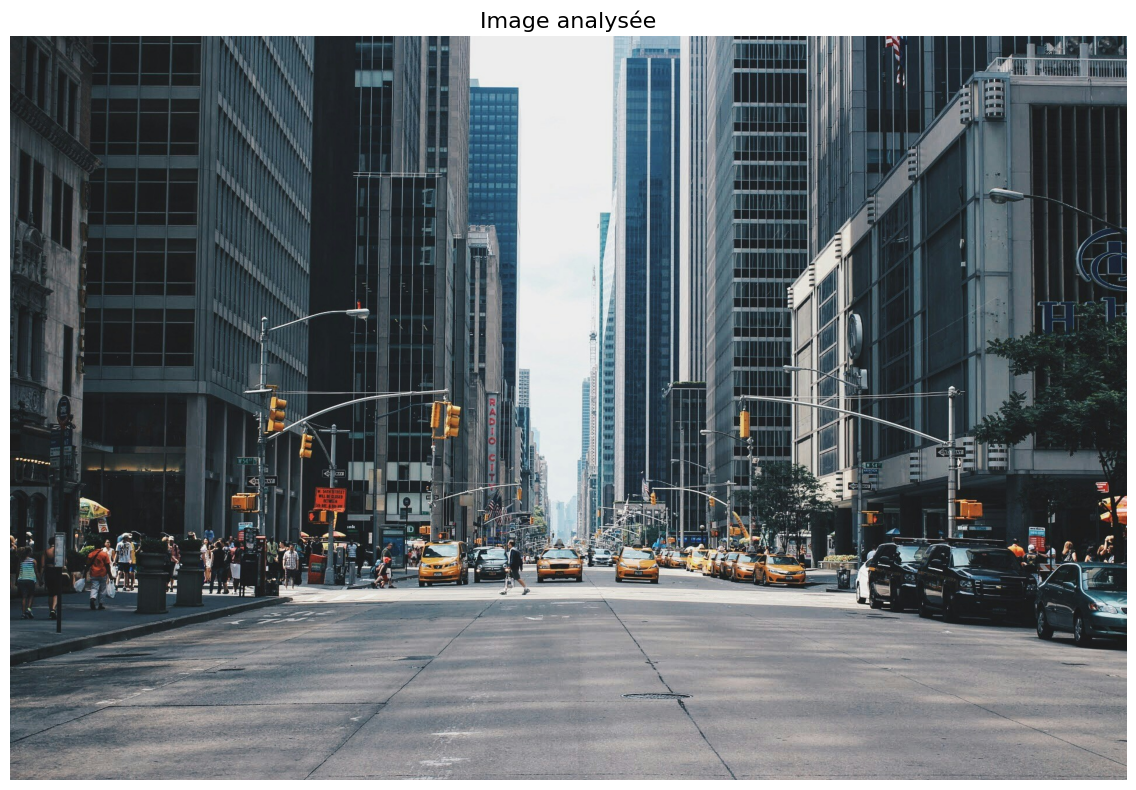

a city street with cars and people walking



In [57]:
!wget -q https://images.unsplash.com/photo-1449824913935-59a10b8d2000 -O test_scene.jpg 2>/dev/null || echo "Image téléchargée"


analyser_scene_complete('test_scene.jpg', modele='blip')


# Module 4

In [58]:
# In this module, we will use a image classification model to recognize the main objects in an image.
# This model should be good at recognizing everyday objects such as food, household items, etc.


In [59]:
## Image classification model (ImageNet)

In [60]:
import torch
from torchvision import models, transforms
from PIL import Image
import json
import requests
from io import BytesIO

# Select a lightweight ImageNet model for CPU
_device_cls = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Module 4 - classification device: {_device_cls}")

# We will load the model and preprocessing only once and reuse them
_imagenet_model = None
_imagenet_preprocess = None
_imagenet_idx_to_label = None

def load_imagenet_classifier(model_name: str = "resnet18"):
    """Load a pretrained ImageNet classifier and preprocessing pipeline.

    Args:
        model_name: torchvision model name (e.g. "resnet18", "resnet50").
    """
    global _imagenet_model, _imagenet_preprocess, _imagenet_idx_to_label

    if _imagenet_model is not None:
        return _imagenet_model, _imagenet_preprocess, _imagenet_idx_to_label

    # Load pretrained model
    if model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        weights = models.ResNet18_Weights.DEFAULT
    elif model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        weights = models.ResNet50_Weights.DEFAULT
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")

    model.eval()
    model.to(_device_cls)

    # Preprocessing and labels from weights meta
    preprocess = weights.transforms()
    idx_to_label = weights.meta["categories"]

    _imagenet_model = model
    _imagenet_preprocess = preprocess
    _imagenet_idx_to_label = idx_to_label

    return model, preprocess, idx_to_label


Module 4 - classification device: cpu


In [61]:
from typing import List, Tuple


def classify_image_imagenet(image_path: str, top_k: int = 5) -> List[Tuple[str, float]]:
    """Run ImageNet classification on a single image.

    Args:
        image_path: path to image file (local path).
        top_k: number of top predictions to return.

    Returns:
        List of (label, probability) sorted by probability descending.
    """
    model, preprocess, idx_to_label = load_imagenet_classifier()

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(_device_cls)

    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

    top_probs, top_idxs = probabilities.topk(top_k)

    results = []
    for prob, idx in zip(top_probs, top_idxs):
        label = idx_to_label[int(idx)]
        results.append((label, float(prob)))

    return results


In [62]:
def summarize_classification_results(results: List[Tuple[str, float]]) -> str:
    """Create a short, spoken-style summary from top ImageNet predictions.

    Args:
        results: list of (label, probability) pairs.

    Returns:
        English sentence describing the main objects.
    """
    if not results:
        return "No objects could be confidently recognized in this image."

    # Build a simple description using top 3 predictions
    top_descriptions = []
    for label, prob in results[:3]:
        percent = int(round(prob * 100))
        top_descriptions.append(f"{label} ({percent} percent)")

    if len(top_descriptions) == 1:
        description = f"The main object is likely {top_descriptions[0]}."
    else:
        main = ", ".join(top_descriptions[:-1])
        last = top_descriptions[-1]
        description = f"The main objects are probably {main} and {last}."

    return description


In [63]:
def classify_and_describe_image(image_path: str, top_k: int = 5, show_image: bool = True):
    """High-level helper: classify an image and print a description.

    Args:
        image_path: path to image file.
        top_k: number of top predictions to print.
        show_image: whether to display the image with matplotlib.
    """
    print(f"CLASSIFICATION - IMAGE: {image_path}")

    # Optionally display the image
    if show_image:
        image = Image.open(image_path).convert("RGB")
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis("off")
        plt.title("Image for classification", fontsize=14)
        plt.tight_layout()
        plt.show()

    # Run classifier
    results = classify_image_imagenet(image_path, top_k=top_k)

    print("Top predictions (ImageNet):")
    for i, (label, prob) in enumerate(results, start=1):
        print(f"{i}. {label} - {prob:.3f}")

    summary = summarize_classification_results(results)
    print("\nSummary:")
    print(summary)

    return {
        "predictions": results,
        "summary": summary,
    }


CLASSIFICATION - IMAGE: banana.jpg


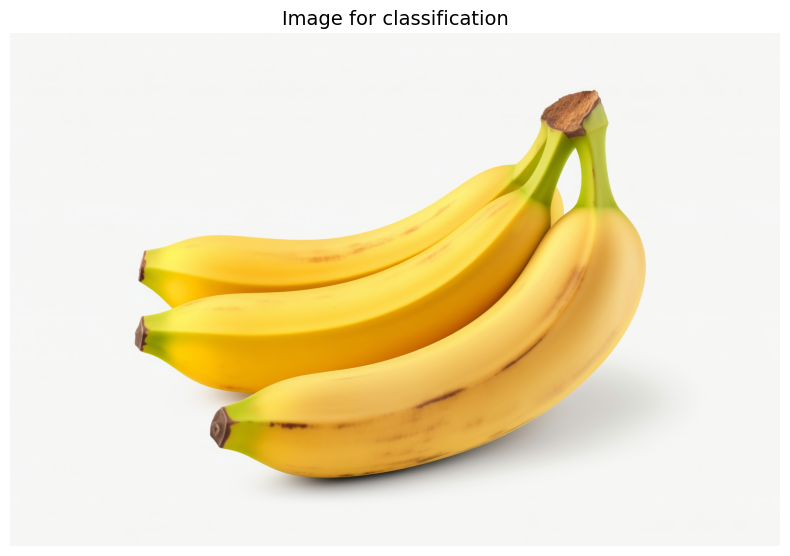

Top predictions (ImageNet):
1. banana - 1.000
2. mortar - 0.000
3. spaghetti squash - 0.000
4. lemon - 0.000
5. butternut squash - 0.000

Summary:
The main objects are probably banana (100 percent), mortar (0 percent) and spaghetti squash (0 percent).


{'predictions': [('banana', 0.9995242357254028),
  ('mortar', 5.5260166845982894e-05),
  ('spaghetti squash', 5.2270152082201093e-05),
  ('lemon', 3.939542511943728e-05),
  ('butternut squash', 3.243683386244811e-05)],
 'summary': 'The main objects are probably banana (100 percent), mortar (0 percent) and spaghetti squash (0 percent).'}

In [64]:
# Example usage for Module 4 (you can change the image path)

image_path = 'banana.jpg'

# Classify the sample image

classify_and_describe_image(image_path, top_k=5, show_image=True)


CLASSIFICATION - IMAGE: salt_shaker.jpg


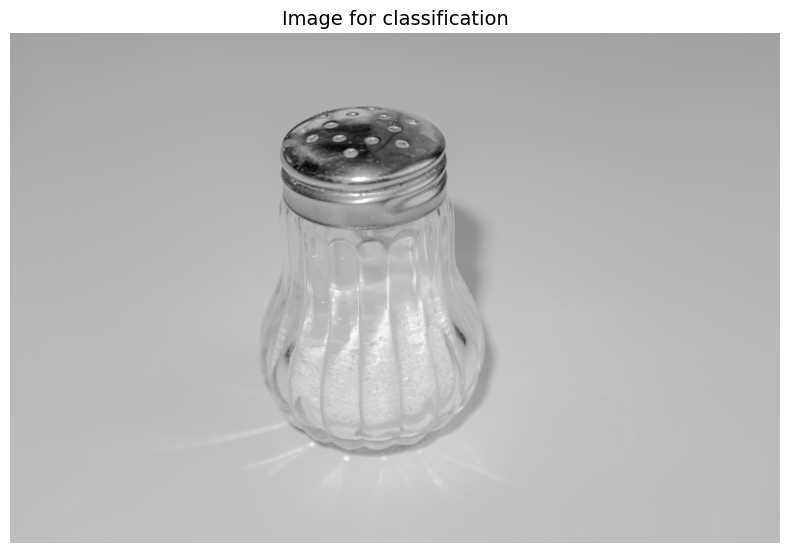

Top predictions (ImageNet):
1. saltshaker - 0.996
2. thimble - 0.001
3. pop bottle - 0.001
4. vase - 0.000
5. water bottle - 0.000

Summary:
The main objects are probably saltshaker (100 percent), thimble (0 percent) and pop bottle (0 percent).


{'predictions': [('saltshaker', 0.9962109327316284),
  ('thimble', 0.0012356158113107085),
  ('pop bottle', 0.0010203240672126412),
  ('vase', 0.000356557487975806),
  ('water bottle', 0.00019869425159413368)],
 'summary': 'The main objects are probably saltshaker (100 percent), thimble (0 percent) and pop bottle (0 percent).'}

In [65]:
# Example usage for Module 4 (you can change the image path)

image_path = 'salt_shaker.jpg'

# Classify the sample image

classify_and_describe_image(image_path, top_k=5, show_image=True)


# Main Module
In this module, we run all the modules on one example.
This means for 1 image, we will:
Module 1 (YOLO - object detection) 
Module 2 (OCR - text in image)
Module 3 (CLIP/BLIP - Scene Description ) 
Module 4 (Object classification) 


Module 1: Object Detection


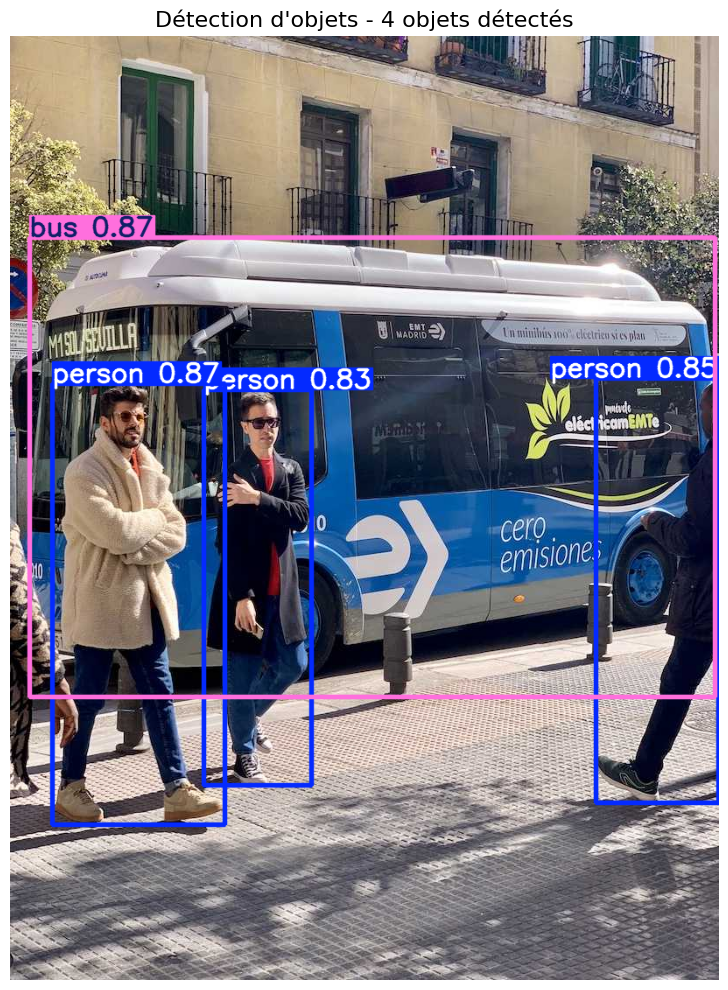

1.  Bus devant vous, TRÈS PROCHE - ATTENTION
2.  Personne détectée à gauche, Distance moyenne
3.  Personne détectée à droite, Distance moyenne
4.  Personne détectée devant vous, Distance moyenne
Analyse de la scène : 4 obstacle(s) détecté(s). Bus devant vous, très proche - attention. Personne détectée à gauche, distance moyenne. Personne détectée à droite, distance moyenne. Au total, 4 objets dans la scène : 3 person, 1 bus.
1. bus (confiance: 0.87) - devant vous, TRÈS PROCHE - ATTENTION
2. person (confiance: 0.87) - à gauche, Distance moyenne
3. person (confiance: 0.85) - à droite, Distance moyenne
4. person (confiance: 0.83) - devant vous, Distance moyenne
--------------------------------------------------
Module 2: Text in Image
ANALYSE DE: /content/img1_Simple.png
Méthode: EASYOCR, Mode: panneaux
Erreur: impossible de charger /content/img1_Simple.png
--------------------------------------------------
Module 3: Scene Description
ANALYSE COMPLÈTE DE LA SCÈNE: test_scene.jpg
Modèle: B

[ WARN:0@3811.337] global loadsave.cpp:275 findDecoder imread_('/content/img1_Simple.png'): can't open/read file: check file path/integrity


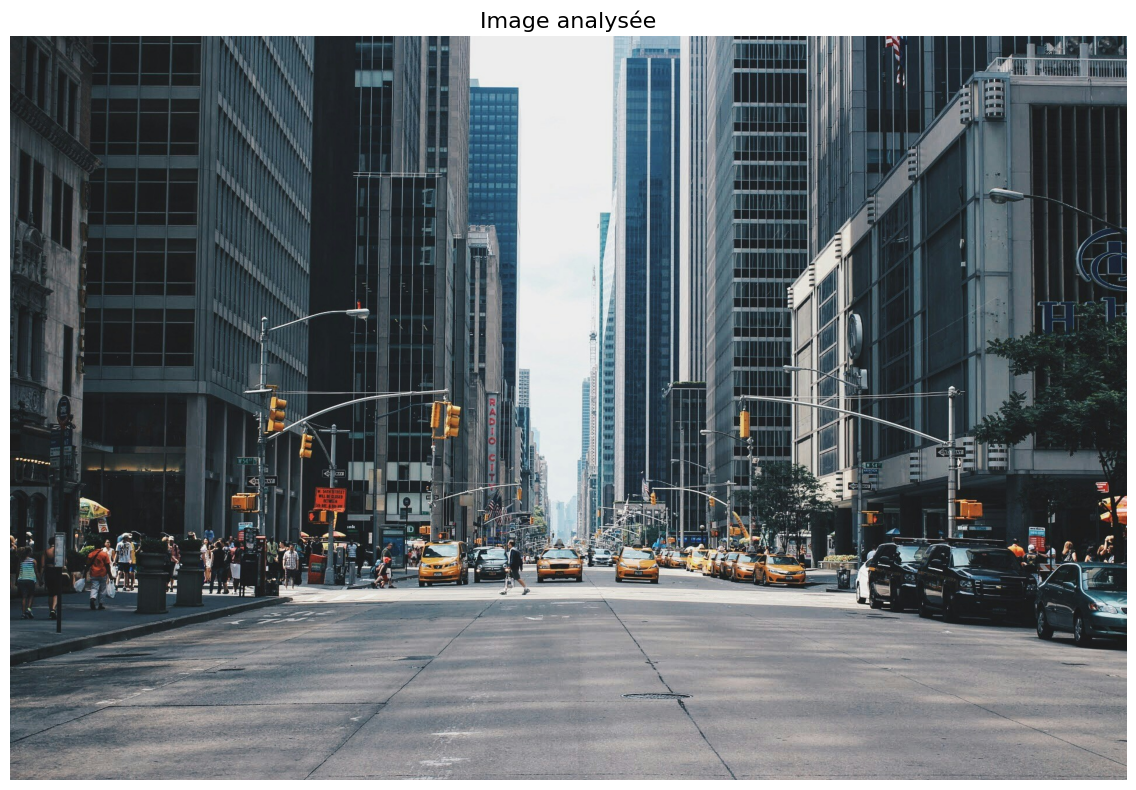

a city street with cars and people walking

--------------------------------------------------
Module 4: Object Classification
CLASSIFICATION - IMAGE: salt_shaker.jpg


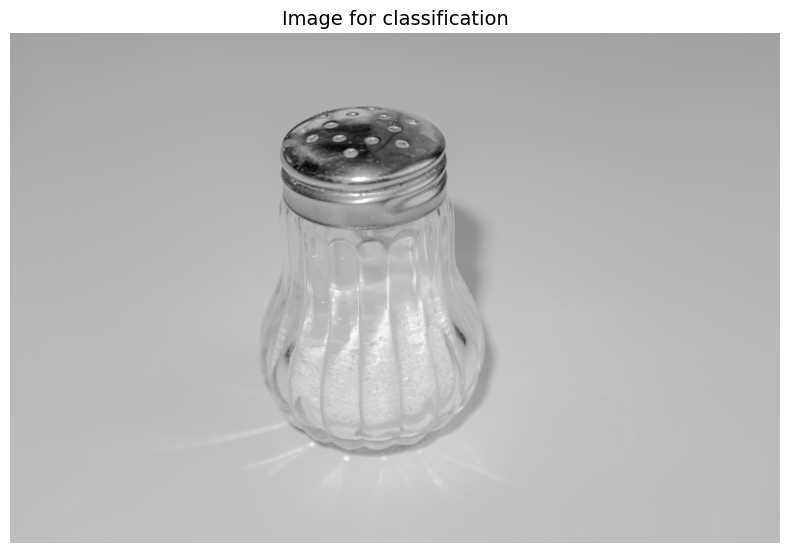

Top predictions (ImageNet):
1. saltshaker - 0.996
2. thimble - 0.001
3. pop bottle - 0.001
4. vase - 0.000
5. water bottle - 0.000

Summary:
The main objects are probably saltshaker (100 percent), thimble (0 percent) and pop bottle (0 percent).
--------------------------------------------------


In [ ]:
image_path = 'salt_shaker.jpg'
mode = "panneaux" # or "etiquettes"
print("Module 1: Object Detection")
afficher_resultats(image_path, conf_threshold=0.5)
print("-"*50)
print("Module 2: Text in Image")
analyser_texte_image(image_path, methode='easyocr', mode=mode)
print("-"*50)
print("Module 3: Scene Description")
analyser_scene_complete(image_path, modele='blip')
print("-"*50)
print("Module 4: Object Classification")
classify_and_describe_image(image_path, top_k=5, show_image=True)
print("-"*50)